# Activity Detection using IMU Dataset

In [1]:
import pandas as pd
import numpy as np
import json
import peakutils
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import seaborn as sns

/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/ratulesrar/anaconda3/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be 

In [2]:
# import helper functions to process IMU data
%run cleaner.py

In [3]:
# create dataframe of sensor data
master = master()

In [4]:
# create splits for training and testing 
# train using 75% of data, test on 25%
X_train, X_test, y_train, y_test = splits(master)

In [5]:
# hyperparameter selection for linear SVM model
# intitialize validation curve for model
C_params = np.logspace(-6, 3, 10)
svc_2 = LinearSVC(random_state = 1234)

train_scores, test_scores = validation_curve(
    svc_2, X_train.values, y_train.values.flatten(),
    param_name="C", param_range=C_params,
    cv=2, scoring="accuracy", n_jobs=-1)

In [6]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

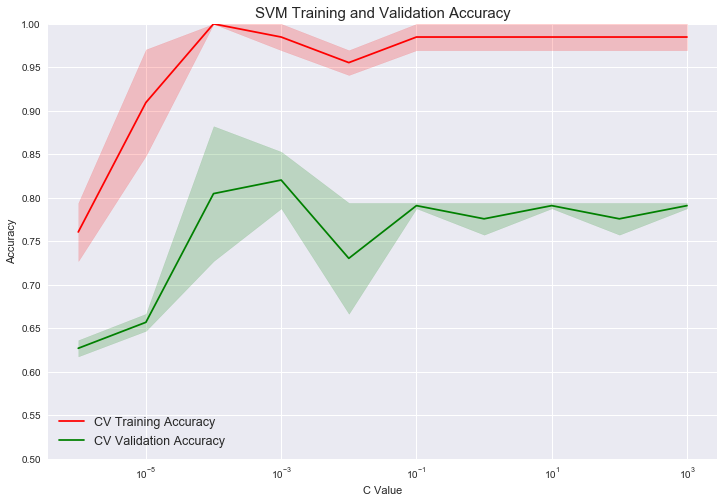

In [7]:
# plot validation curve
y_min = 0.5
y_max = 1.0

f = plt.figure(figsize = (12, 8))
ax = plt.axes()
sns.set(font_scale = 1.25)
sns.set_style("darkgrid")
plt.title("SVM Training and Validation Accuracy")
plt.xlabel("C Value")
plt.ylabel("Accuracy")
plt.ylim(y_min, y_max)
plt.yticks(np.arange(y_min, y_max + .01, .05))
plt.semilogx(C_params, train_scores_mean, label="CV Training Accuracy", color="red")
plt.fill_between(C_params, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="red")
plt.semilogx(C_params, test_scores_mean, label="CV Validation Accuracy",
             color="green")
plt.fill_between(C_params, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="green")
plt.legend(loc="best")
plt.show()

In [8]:
# train gridsearch model
# using rbf and linear kernel
Cs = np.logspace(-6, 3, 10)
parameters = [{'kernel': ['rbf'], 'C': Cs},
              {'kernel': ['linear'], 'C': Cs}]

svc = SVC(random_state = 1234)

clf = GridSearchCV(estimator = svc, param_grid = parameters, cv = 2, n_jobs = -1)
clf.fit(X_train.values, y_train.values)

GridSearchCV(cv=2, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1234, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['rbf'], 'C': array([  1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03])}, {'kernel': ['linear'], 'C': array([  1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [9]:
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1234, shrinking=True,
  tol=0.001, verbose=False)
{'kernel': 'linear', 'C': 0.0001}
0.8059701492537313


In [10]:
# print accuracy score for model
clf.score(X_test, y_test)

0.95652173913043481

In [11]:
# check baseline accuracy
# this is the number we would get if we had no features in the model
y_test.value_counts().values[0] / y_test.value_counts().values.sum()

0.30434782608695654

In [12]:
# create dataframe of activity labels
label_desc_df = pd.DataFrame(master.activity.unique().tolist(), columns = ['activity'])
label_num_df = pd.DataFrame(master.activity_factor.unique().tolist(), columns = ['activity_factor'])
activity_df = pd.concat([label_num_df, label_desc_df], axis=1)

In [13]:
# create crosstab to display model evaluation
crosstab = pd.crosstab(y_test.values.flatten(), clf.predict(X_test),
                          rownames=['True'], colnames=['Predicted'],
                          margins=True)
crosstab

Predicted,0,1,2,3,All
True,,,,,
0,3,0,0,0,3
1,0,7,0,0,7
2,0,1,5,0,6
3,0,0,0,7,7
All,3,8,5,7,23


In [14]:
# add labels to crosstab
crosstab_clean = crosstab.iloc[:-1, :-1]
crosstab_clean.columns = activity_df.activity.values
crosstab_clean.index = activity_df.activity_factor.values
crosstab_clean

,Driving,Standing,Walking,Jumping
0,3,0,0,0
1,0,7,0,0
2,0,1,5,0
3,0,0,0,7
